#Main imports

In [1]:
!pip install numdifftools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.4 MB/s eta 0:00:00


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/ImagenesTFM'

Mounted at /content/gdrive


In [2]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd
import time as tm
import scipy as sci
import tensorflow as tf

from sympy.utilities.lambdify import lambdify
from scipy.optimize import curve_fit

print(np.__version__)
print(nd.__version__)

1.23.5
0.9.41


# Reverse Polish notation, reading and writting related functions

This code's final objective is to generate a set of dependencies with which compare the data to check if any of them describes the data. The dependencies generated will be expressed  in strings in reverse polish notation (RPN).

Here are the reading and writting RPN related functions.

In [4]:
'''
Find_first_opn (s: string)

Given a string s, in which the last character is a binary operation; returns the first operand's last position.
'''

def Find_first_opn(s):
    L = len(s)
    if s[L-1] == '>' or s[L-1] == '<' or s[L-1] == '~':
        return Find_first_opn(s[:L-1]) + 1
    elif s[L-1] == '+' or s[L-1] == '-' or s[L-1] == '*' or s[L-1] == '/':
        aux = Find_first_opn(s[:L-1])
        return Find_first_opn(s[:L-1-aux]) + aux + 1
    else:
        return 1


#Dictionary with the binary operations (except product)
Bin_op = {'+': sym.Add, '/': lambda x,y: sym.Mul(x,sym.Pow(y,-1))}

'''
LeerOp (s: string, var: list)

Translates the formula in s expressed in RPN to sympy.
In the lists var and params are stored the variables' and parameters' names.
'''

def LeerOp(s, var,n_params=0):
    L = len(s)

    for i in range(len(var)):
        if s[L-1] == sym.srepr(var[i])[sym.srepr(var[i]).find('(')+2:sym.srepr(var[i]).find(')')-1]:
            return var[i],[]

    if s[L-1] == '1':
        return 1,[]
    if s[L-1] == '>' or s[L-1] == '<' or s[L-1] == '~' or s[L-1] == 'c':
        input,params = LeerOp(s[:L-1], var, n_params)
        if s[L-1] == '>':
            return input + 1,params
        elif s[L-1] == '<':
            return input - 1,params
        elif s[L-1] == '~':
            return -input,params
        elif s[L-1] == 'c':
            return sym.cos(input),params

    if s[L-1] == '*':
        return Mult(s, var, n_params)

    for i in Bin_op:
        if s[L-1] == i:
            aux2 = Find_first_opn(s[:L-1])
            lop_1,params1 = LeerOp(s[:L-1-aux2], var, n_params)
            lop_2,params2 = LeerOp(s[:L-1], var, len(params1)+n_params)
            params = params1 + params2
            return Bin_op[i](lop_1, lop_2), params

    n_var=len(var)
    var.append(sym.symbols(s[L-1]))
    return var[n_var], []


'''
Mult (s:string, var:list)

Does the multiplication operation. Given the string s in RPN which most general operation is a multiplication. It is needed because of
how the codes introduces the parameters. var is the variables' names list.
'''

def Mult(s, var, n_params):
    if s[len(s)-2] == 'ç':
        op,params = LeerOp(s[:len(s)-2], var,n_params)
        params.append(sym.Symbol('par'+str(n_params+len(params))))
        return sym.Mul(params[len(params)-1], op),params
    s_aux = s
    should_restart = True
    par_pres = False
    while should_restart:
        should_restart = False

        L = len(s_aux)
        aux1 = Find_first_opn(s_aux[:L-1])
        aux2 = Find_first_opn(s_aux[:L-1-aux1])
        for i_char in range(L-1-aux1-aux2,L-1):
            if s_aux[i_char] == 'ç':
                s_aux = s_aux[:i_char]+s_aux[i_char+2:]

                if not par_pres:
                    par_pres = True
                should_restart = True
                break

    aux2 = Find_first_opn(s_aux[:L-1])
    lop_1,params1 = LeerOp(s_aux[:L-1-aux2], var, n_params)
    lop_2,params2 = LeerOp(s_aux[:L-1], var, len(params1)+n_params)
    params = params1 + params2
    if par_pres:
        params.append(sym.Symbol('par'+str(n_params+len(params))))
        return sym.Mul(params[len(params)-1],sym.Mul(lop_1, lop_2)),params
    else:
        return sym.Mul(lop_1, lop_2),params


'''
Intr_param (expr: string)

expr is in RPN. In expr are introduced the character 'ç' in certain positions. Then in the Mult function, those may be replaced with a parameter,
depending if it is redundant or not.
'''

def Intr_param(expr):
    should_restart = True
    while should_restart:
        should_restart = False
        for i in range(len(expr)):
            l = expr[i]
            if l != '0' and l != '<' and l != '>' and l != '~' and l != '+' and l != '*' and l != 'ç' and l != '/':
                if i > len(expr)-3:
                    expr = expr[:i+1]+'ç*'+expr[i+1:]
                    should_restart = True
                    break
                else:
                    if expr[i+1:i+3] != 'ç*':
                        expr = expr[:i+1]+'ç*'+expr[i+1:]
                        should_restart = True
                        break
    return expr




In [5]:
'''
Reverse Polish notation strings generation
'''

Un_op = ['c']
Bin_op_sim = ['+', '*']

'''
Gen_string(n:int, d:dictionary):

Returns all dependencies with length n from the dictionary d, which contains all dependencies with length between 1 and n-1.
'''

def Gen_string(n, d):
    d[n] = []
    for s_menos1 in d[n-1]:
        for op_un in Un_op:
            d[n].append(s_menos1 + op_un)
    if n>2:
        for op_sim in Bin_op_sim:
            for i in range(1,(n-1)//2+1):
                #print(i)
                for s_op1 in d[i]:
                    for s_op2 in d[n-i-1]:
                        d[n].append(s_op1 + s_op2 + op_sim)

        for i in range(1, n-2):
            for s_op1 in d[i]:
                for s_op2 in d[n-i-1]:
                    d[n].append(s_op1 + s_op2 + '/')

'''
Gen_string_1ton(n_max:int,var:list)

Generates a dictionary with all dependencies with length between 1 and n_max in RPN. The list var contains all the variables' names.
'''

def Gen_string_1ton(n_max, var):
    l_1 = var
    l_1.append('1')
    d = {1:l_1}
    for n in range(2,n_max+1):
        Gen_string(n, d)
    return d


# Generation of test dataset

All the tests have been made with the input dataset generated with the function $f(x)=x^4+1$.

## Polynomic function

In [6]:
'''
func_pol(coef,x)

Polynomic function where coef is the coefficients list
'''

def func_pol(coef,x):
    y_f=0
    for i in range(len(coef)):
        y_f+=coef[i]*x**i
    return y_f

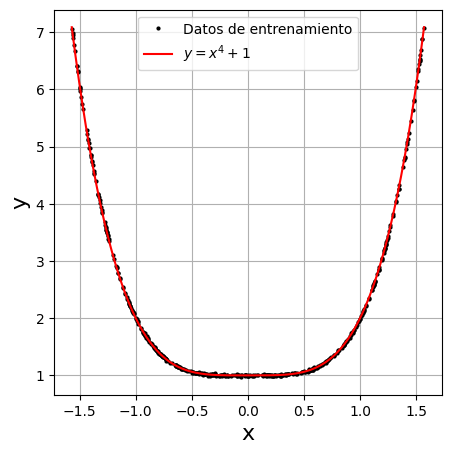

In [ ]:
N_data=500
mu_err=0
sigma_err=.01
coef = [1, 0, 0, 0, 1]
lim = np.pi/2
x=lim*(2*np.random.rand(N_data)-1)
err=sigma_err*np.random.randn(N_data)+mu_err
y=func_pol(coef,x)+err

Data_train=[x,y]

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(Data_train[0], Data_train[1], 'ko', markersize=2, label='Datos de entrenamiento')
t=np.linspace(-lim,lim,200)
f=func_pol(coef,t)

ax.plot(t, f, '-', c='r', linewidth=1.5, label='$y=x^4+1$')
plt.legend()

plt.grid()
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)
#plt.savefig(f"{images_dir}/DataGen.png")
plt.show()

# Test 0: rivial symbolic regression

As a first try of the code's structure a trivial case is built. The optimization method is a basic gradient descent built in this code, except for a function that returns the given function's gradient. This test restricts the search to the target function's dependency, $f(x)=a_4x^4+a_0$.

## Optimization method's functions



In [ ]:
'''
Build_Lossf(Data_exp,func_aj,var_sym,params_sym)

Function to build the Loss function given the experimental data, Data_exp, the tested function, func_aj (in Sympy).
var_sym and params_sym are lists that contain the variables' and parameters' symbolic names.
'''

def Build_Loss(Data_exp, func_aj, var_sym, params_sym):
    def Loss(params_num):
        c=0
        paramsC = params_sym
        func_aux = func_aj
        for i in range(1,len(params_num)):
            func_aux = func_aux.subs(paramsC[i-1],params_num[i])
        for i in range(len(Data_exp[0])):
            for j in range(len(var_sym)):
                l+=(func_aux.subs(var_sym[j],Data_exp[j][i])+params_num[0]-Data_exp[len(Data_exp)-1][i])**2
        return float(l/len(Data_exp[len(Data_exp)-1]))
    return Loss


'''
Optimization (i_max, Loss, params_ini, learn_rate)

Function that returns the optimal parameters given the Loss function, the parameters' initial values params_ini, the learning rate learn_rate,
and the maximum number of iterations i_max.
'''

def Optimization (i_max, Loss, params_ini, learn_rate):
    params_num = [params_ini]
    for k in range(len(params_sym)):
        params_num.append(params_ini)
    for i_opt in range(i_max):
        grad=nd.Gradient(Loss)(params_num)
        v_t = learn_rate*grad
        params_num -= v_t
    return params_num

## Trivial search

In [ ]:
'''
depend (Dictionary): Contains the test functions in RPN
func_test (Dictionary): Similar to depend but with the 'ç' characters for the parameters.
params_ini (float): Parameters' initial value.
'''

var = ['x']
var_sym = [sym.symbols(variable) for variable in var]
params_ini = 0

depend = 'xx*x*x*'
learn_rate = 1.*10**-1
i_max = 20

func_test = Intr_param(depend)

func_sym,params_sym = LeerOp(func,var_sym)
CostFunction = Build_Cost(Data_train, func_sym, var_sym, params_sym)
params_num = Optimization(i_max,CostFunction,params_ini,learn_rate)
Coste = CostFunction(params_num)
func_aux2 = func_sym
for i in range(1,len(params_num)):
    func_aux2 = func_aux2.subs(params_sym[i-1],params_num[i])
f_val = func_aux2 + params_num[0]
BestOpt = [func, f_val, params_num]
print(Coste,': ',BestOpt)

0.0021456012300014094 :  ['xç*xç**xç**xç**', 1.02059442083851*x**4 + 0.941935562534311, array([0.94193556, 1.02059442])]


## Graphic representation

1.02059442083851*x**4 + 0.941935562534311


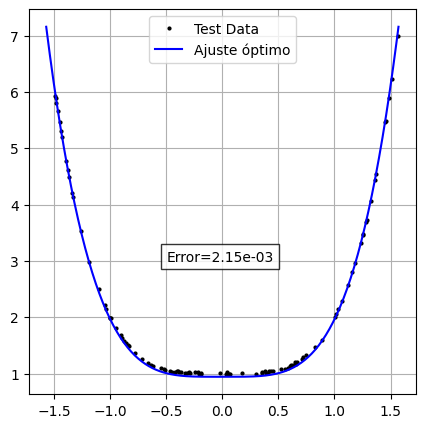

In [ ]:
names = ['$x^4$']
depend = ['xx*x*x*']
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
props = dict(facecolor='white',alpha=0.8)

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(Data_test[0], Data_test[1], 'ko', markersize=2, label='Test Data')
t = np.linspace(-np.pi,np.pi,200)/2
print(BestOpt[1])
#func_lambda = lambdify(var_sym,BestOpt[1], 'numpy')
f_pred = lambdify(var_sym,BestOpt[1], 'numpy')(t)
ax.plot(t, f_pred, '-', c='blue', linewidth=1.5, label='Ajuste óptimo')
ax.text(-0.5,3,f'Error={Coste:.2e}',bbox=props)
plt.legend()
plt.grid()
#plt.savefig(f"{images_dir}/base1.png")
plt.show()

#Test 1: Restricted symbolic regression. Optimization method comparison.

+ Input (target function RS): $y(x)=x^4 +1$
+ Function space studied:
  *   $x^2$
  *   $x^4+x^2$
  *   $x^3$
  *   $x^3+x^2$
  *   $x^4$
+ Advanced optimization methods (scipy & red neuronal)

Once seen that the code can fit good enough the target function, we proceed to give it a collection of function between it has to select the target function.

In addition, we also use this test to compare two advanced optimization methods. The method used in the test 0 was nice to understand how usual optimization methods work, but it is really inefficient. The two methods compared are:

+ SciPy's curve_fit function. This function returns the optimal parameters of a given single variable function and a dataset to fit it.

+ Neural network's technology. Taking advantage of Keras' class *Layer*, use optimization techniques of Keras' library used in neural networks.


## First method: *SciPy*'s *curve_fit* function


The *SciPy*'s *curve_fit* function fits a parametrized single variable function to a given dataset.






In [ ]:
'''
depend (List): Contains the test functions in RPN
func_test (List): Similar to depend but with the 'ç' characters for the parameters.
var: List of variables' names as characters.
var_sym(list): List of SymPy's variable's names.
'''

var = ['x']
var_sym = [sym.symbols(variable) for variable in var]

depend = ['xx*x*x*', 'xx*', 'xx*x*x*xx*+','xx*x*','xx*x*xx*+']
func_test = [Intr_param(expression) for expression in depend]
print(func_test)

Results = []
t_inicial = tm.time()
for func in func_test:
    func_sym,params_sym = LeerOp(func,var_sym)
    ind_term = sym.symbols("par"+str(len(params_sym)))
    func_sym = func_sym + ind_term
    params_sym.append(ind_term)
    print('\n',func_sym,':\nParameters\' names:',params_sym)
    func_lambda = lambdify(var_sym + params_sym,func_sym, 'numpy')
    try:
        optimal = curve_fit(func_lambda,Data_train[0],Data_train[1])
        params_num = optimal[0]
        Results.append([func_sym,func_lambda,params_num])
        print('Optimal parameters = ',params_num)
    except:
        print(f'La función {func_sym} no tiene un buen ajuste')
tiempo1 = tm.time() - t_inicial
print(tiempo1)
print(Results)

['xç*xç**xç**xç**', 'xç*', 'xç*xç**xç*xç**xç**+']

 par0*x**4 + par1 :
Parameters' names: [par0, par1]
Optimal parameters =  [0.99986202 1.00082761]

 par0*x + par1 :
Parameters' names: [par0, par1]
Optimal parameters =  [-0.15695095  2.36892228]

 par0*x**2 + par1*x**3 + par2 :
Parameters' names: [par0, par1, par2]
Optimal parameters =  [ 2.19951845 -0.01524231  0.43167613]
0.027859926223754883
[[par0*x**4 + par1, <function _lambdifygenerated at 0x7c380992aa70>, array([0.99986202, 1.00082761])], [par0*x + par1, <function _lambdifygenerated at 0x7c380992b400>, array([-0.15695095,  2.36892228])], [par0*x**2 + par1*x**3 + par2, <function _lambdifygenerated at 0x7c380992b0a0>, array([ 2.19951845, -0.01524231,  0.43167613])]]


### Optimal function selection

In [ ]:
def Loss(f,x,y,params):
    l = 0
    for i in range(len(x)):
        l += (f(x[i],*params)-y[i])**2
    return l
l_opt = 100
for option in Results:
    l = Loss(option[1],Data_test[0],Data_test[1],option[2])

    try:
        #print(option[0],l,l_opt)
        if l<l_opt:
            l_opt = l
            Best_Opt = option
    except:
        l_opt = l
        Best_Opt = option

print(Best_Opt)

### Graphic representation

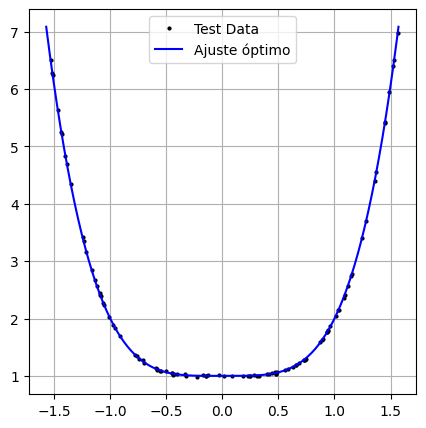

In [ ]:
#Optimal function found plot

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(Data_test[0], Data_test[1], 'ko', markersize=2, label='Test Data')
t = np.linspace(-lim,lim,200)
f_pred = Best_Opt[1](t,*Best_Opt[2])
ax.plot(t, f_pred, '-', c='blue', linewidth=1.5, label='Ajuste óptimo')
plt.legend()
plt.grid()
plt.savefig(f"{images_dir}/1optmethod1.png")
plt.show()

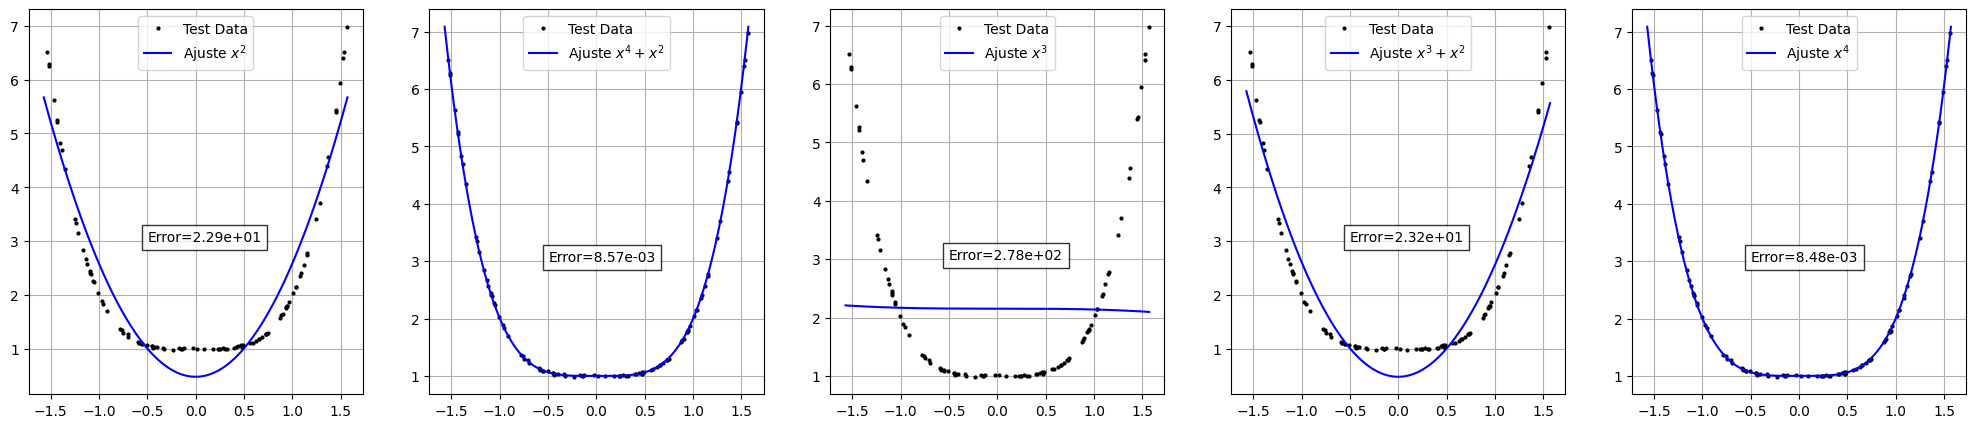

In [ ]:
names = ['$x^2$','$x^4+x^2$','$x^3$','$x^3+x^2$','$x^4$']
depend = ['xc', 'xx*', 'xx*x*x*xx*+','xx*x*','xx*x*xx*+','xx*x*x*']
props = dict(facecolor='white',alpha=0.8)

fig,ax = plt.subplots(1,len(Results),figsize=(5*len(Results),5))
for i in range(len(Results)):
    ax[i].plot(Data_test[0], Data_test[1], 'ko', markersize=2, label='Test Data')
    t = np.linspace(-np.pi,np.pi,200)/2
    f_pred = Results[i][1](t,*Results[i][2])
    ax[i].plot(t, f_pred, '-', c='blue', linewidth=1.5, label='Ajuste '+names[i])#+names[i])

    ax[i].text(-0.5,3,f'Error={Loss(Results[i][1],Data_test[0],Data_test[1],Results[i][2]):.2e}',bbox=props)
    ax[i].legend()
    ax[i].grid()

plt.savefig(f"{images_dir}/1optmethod2.png")
plt.show()

## Second method: A neural network layer

This method uses the *Keras*' class *Layer* to take advantage of neural network's optimization methods.

In [ ]:
# Tensorflow Keras packages
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers,Model

In [ ]:
class FuncLayer_Opt(tf.keras.layers.Layer):
    def __init__(self,
                 num_params,
                 params_initializer=tf.keras.initializers.GlorotUniform(),
                 **kwargs):
        super(FuncLayer_Opt, self).__init__(**kwargs)
        self.params_initializer=params_initializer
        self.num_params = num_params

    def build(self, input_shape):
        self.params = []
        for i in range(self.num_params):
            self.params.append(self.add_weight(name=f'params{i}',
                            shape=[input_shape[-1], 1],
                            initializer=self.params_initializer,
                            #initializer=tf.keras.initializers.Constant(value=1),
                            trainable=True))

    def call(self, inputs, function):
        #print(type(self.params),*self.params)
        output = function(inputs, *self.params)
        return output

### Optimal method selection

In [ ]:
Data_train_NN = [Data_train[0][0:int(0.75*len(Data_train[0]))],Data_train[1][0:int(0.75*len(Data_train[0]))]]
Data_val = [Data_train[0][int(0.75*len(Data_train[0])):],Data_train[1][int(0.75*len(Data_train[0])):]]
print(len(Data_train_NN[0]))
var = ['x']
var_sym = [sym.symbols(variable) for variable in var]

depend = ['xx*x*x*', 'xx*', 'xx*x*x*xx*+','xx*x*','xx*x*xx*+']
func_test = [Intr_param(expression) for expression in depend]
print(func_test)

Results = []
histories = {}
models = {}
layers = {}

# Define the metrics, optimizer and loss
optimizer=RMSprop()
loss=tf.keras.losses.mean_squared_error
metrics=tf.keras.metrics.MeanSquaredError()

batch_size = 32
epochs = 100
t_inicial = tm.time()
for func in func_test:
    func_sym,params_sym = LeerOp(func,var_sym)
    ind_term = sym.symbols("par"+str(len(params_sym)))
    func_sym = func_sym + ind_term
    params_sym.append(ind_term)
    print('\n',func_sym,':\nParameters\' names:',params_sym)
    func_lambda = lambdify(var_sym + params_sym,func_sym, 'numpy')
    Layer = FuncLayer_Opt(num_params=len(params_sym))
    input = tf.keras.layers.Input(shape=(1,))
    output = Layer(input,func_lambda)
    optimizer=RMSprop()
    loss=tf.keras.losses.mean_squared_error
    metrics=tf.keras.metrics.MeanSquaredError()
    models[func] = Model(input,output)
    models[func].compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    histories[func] = models[func].fit(Data_train_NN[0], Data_train_NN[1],
                               batch_size=batch_size,
                               epochs=epochs,
                               verbose=0,
                               validation_data=(Data_val[0], Data_val[1]))
tiempo2 = tm.time() - t_inicial
print(tiempo2)

375
['xç*xç**xç**xç**', 'xç*xç**', 'xç*xç**xç**xç**xç*xç**+', 'xç*xç**xç**', 'xç*xç**xç**xç*xç**+']

 par0*x**4 + par1 :
Parameters' names: [par0, par1]


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(



 par0*x**2 + par1 :
Parameters' names: [par0, par1]

 par0*x**4 + par1*x**2 + par2 :
Parameters' names: [par0, par1, par2]

 par0*x**3 + par1 :
Parameters' names: [par0, par1]

 par0*x**3 + par1*x**2 + par2 :
Parameters' names: [par0, par1, par2]
65.14284873008728


In [ ]:
l = {}
for func in func_test:
    l[func] = histories[func].history['val_loss'][epochs-1]
    print(func,l[func])
    try:
        if l[func]<l[func_opt]:
            func_opt = func
    except:
        func_opt = func

xç*xç**xç**xç** 8.20712884888053e-05
xç*xç** 0.4551997184753418
xç*xç**xç**xç**xç*xç**+ 0.003735561855137348
xç*xç**xç** 3.1496589183807373
xç*xç**xç**xç*xç**+ 0.47311630845069885


### Graphic representation

7/7 [==============================] - 0s 3ms/step


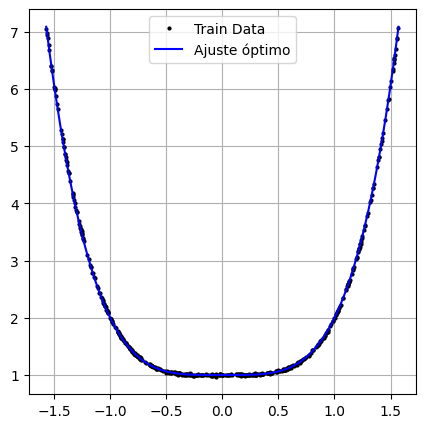

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(Data_train[0], Data_train[1], 'ko', markersize=2, label='Train Data')

t = np.linspace(-lim,lim,200)
f_pred = models[func_opt].predict(t)

ax.plot(t, f_pred, '-', c='blue', linewidth=1.5, label='Ajuste óptimo')
plt.legend()
plt.grid()
#plt.savefig(f"{images_dir}/2optmethod.png")
plt.show()

7/7 [==============================] - 0s 3ms/step


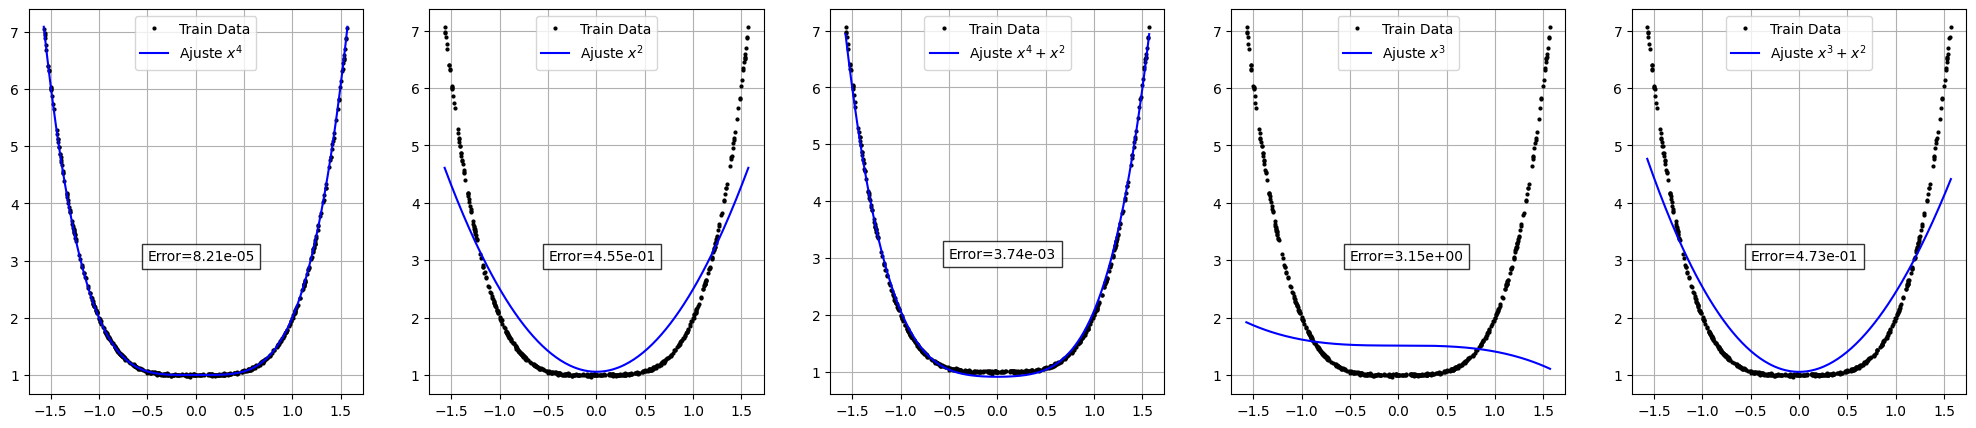

In [ ]:
names = ['$x^4$','$x^2$','$x^4+x^2$','$x^3$','$x^3+x^2$']
depend = ['xx*x*x*', 'xx*', 'xx*x*x*xx*+','xx*x*','xx*x*xx*+']
props = dict(facecolor='white',alpha=0.8)

fig,ax = plt.subplots(1,len(func_test),figsize=(5*len(func_test),5))

t = np.linspace(-lim,lim,200)

for i in range(len(func_test)):
    ax[i].plot(Data_train[0], Data_train[1], 'ko', markersize=2, label='Train Data')
    f_pred = models[func_test[i]].predict(t)
    ax[i].plot(t, f_pred, '-', c='blue', linewidth=1.5, label='Ajuste '+names[i])

    ax[i].text(-0.5,3,f'Error={l[func_test[i]]:.2e}',bbox=props)
    ax[i].legend()
    ax[i].grid()

#plt.savefig(f"{images_dir}/2optmethod2.png")
plt.show()

In [ ]:
params_pred = models[func_opt].get_weights()
print(params_pred)

[array([[0.9999306]], dtype=float32), array([[0.998974]], dtype=float32)]


# (Main)Test 2: General symbolic regression. Function generation.

This is the main test that aims to accomplish this code's objective. Unlike the previous tests which input functions were introduced mannually, it uses the writting functions to produce all the dependencies considered with length between 1 and a given maximum length.

Then, it explores all dependencies considered with the code seen in Test 1 with the SciPy's curve_fit function.

+ Input: $y(x)=x^4+1$
+ Function space studied: All dependencies with length between 1 and a given maximum length (in this case, 8) generated with the following alphabet:
  * Constant: $1$
  * Variable: $x$
  * Unary operation cosinus: $cos(x)$
  * Binary operation sum: $+$
  * Binary operation multiplication: $\cdot$
  * Binary operation division: $/$

### Loss function

In [11]:
def Loss(f,x,y,params):
    l = 0
    for i in range(len(x)):
        l += (f(x[i],*params)-y[i])**2
    return l/len(x)

## Optimal function search

In [ ]:
'''
depend (List): Contains the test functions in RPN
func_test (List): Similar to depend but with the 'ç' characters for the parameters.
var: List of variables' names as characters.
var_sym(list): List of SymPy's variable's names.
'''

var = ['x']
var_sym = [sym.symbols(variable) for variable in var]

depend = Gen_string_1ton(8,var)
Total = 0
for d in depend:
    Total += len(depend[d])
print('Total test dependencies: ',Total)

func_test = {s:[Intr_param(expression) for expression in depend[s]] for s in depend}

n = 0
Results = []
loss_distr = []

t_inicial = tm.time()

for s in func_test:
    print(s)
    for func in func_test[s]:
        try:
            func_sym,params_sym = LeerOp(func,var_sym)
        except:
            print('Error al leer',func,var_sym)
            continue
        ind_term = sym.symbols("par"+str(len(params_sym)))
        func_sym = func_sym + ind_term
        params_sym.append(ind_term)
        func_lambda = lambdify(var_sym + params_sym,func_sym, 'numpy')
        try:
            optimal = curve_fit(func_lambda,Data_train[0],Data_train[1])
            params_num = optimal[0]
            Results.append([func_sym,func_lambda,params_num,func])
            loss_distr.append(Loss(func_lambda,Data_train[0],Data_train[1],params_num))
        except:
            n+=1

tiempo3 = tm.time()-t_inicial
print(tiempo3,t_inicial)

loss_distr = np.array(loss_distr)
print(n)
print(len(Results))

Cantidad de dependencias test:  6596
1
2
3
4
5


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


6
7
8
283.5901598930359 1701650577.4111528
1250
5346


In [ ]:
l_opt = 100
n = 0
subopt = []
for i in range(len(Results)):
    l = Loss(Results[i][1],Data_train[0],Data_train[1],Results[i][2])
    try:
        #print(option[0],l,l_opt)
        if l<l_opt:
            #print(l,Results[i][0])
            l_opt = l
            Best_Opt = Results[i] + [l_opt]
    except:
        l_opt = l
        Best_Opt = Results[i] + [l_opt]

for i in range(len(Results)):
    l = Loss(Results[i][1],Data_train[0],Data_train[1],Results[i][2])
    if l<2*l_opt:
       n+=1
       subopt.append(i)

print(Best_Opt)

2.7051769690008833 par0*x + par1
2.705176969000883 par0*x + par1 + par2
0.22238740818105843 par0*x**2 + par1
0.00010351799486160157 par3*cos(par2*cos(par1*cos(par0*x))) + par4
0.00010351523232288962 par4*cos(par3*cos(par2*cos(par0*x + par1))) + par5
0.00010341005379987385 par5*cos(par1*cos(par0*x**2) + par4*cos(par3*cos(par2*x**2))) + par6
0.00010340986965131466 par2*cos(par1*cos(par0*x**2))/(par6*cos(par5*cos(par4*cos(par3*x**2)))) + par7
[par2*cos(par1*cos(par0*x**2))/(par6*cos(par5*cos(par4*cos(par3*x**2)))) + par7, <function _lambdifygenerated at 0x7c3805dcf7f0>, array([0.40672927, 1.63153745, 2.19376846, 0.32214836, 1.46604826,
       1.09863284, 0.29552586, 1.45272002]), 'xç*xç*xç**cç*cç*cç*/', 0.00010340986965131466]


## Graphic representation

In [ ]:
#Plot de la función óptima encontrada

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(Data_test[0], Data_test[1], 'ko', markersize=2, label='Test Data')
t = np.linspace(-np.pi,np.pi,200)/2
f_pred = Best_Opt[1](t,*Best_Opt[2])
ax.plot(t, f_pred, '-', c='blue', linewidth=1.5, label='Ajuste óptimo')
plt.legend()
plt.grid()
#plt.savefig(f"{images_dir}/FinalTest.png")
plt.show()

### Suboptimal functions

0 f$_0$=34.0*cos(2.1*cos(3.1*cos(0.34*x))) + 18.0, Loss=0.00010351799486160157, Error=0.10455985550652605
5 f$_1$=20.0*cos(4.2*cos(0.57*x)*cos(cos(0.46*x))) + 14.0, Loss=0.0001040339233151825, Error=0.6034759215653871
7 f$_2$=210.0*cos(0.00011*x + 10.0*cos(0.14*x + 7.5e-5) - 7.1) + 210.0, Loss=0.0001096681231002382, Error=6.051891826211164
13 f$_3$=1.0*x**4 + 1.0, Loss=0.00010360246141604624, Error=0.18624118314912655
24 f$_4$=20.0*cos(1.1*cos(0.5*x**2) + 1.3*cos(1.1*cos(0.36*x**2))) + 4.0, Loss=0.00010341005379987385, Error=0.0001780763865206436


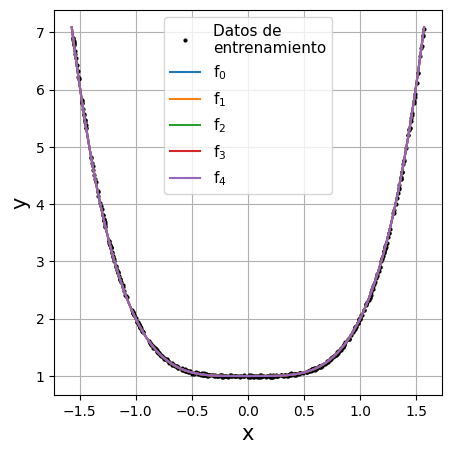

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(Data_train[0],Data_train[1], 'ko', markersize=2, label='Datos de\nentrenamiento')
l = []
subopt_func = []
n = 0
t=np.linspace(-lim,lim,200)
for i in range(len(subopt)):
    l_i = Loss(Results[subopt[i]][1],Data_train[0],Data_train[1],Results[subopt[i]][2])
    siguiente = False
    for j in range(len(l)):
        if abs(l_i-l[j])<10**-8:
            siguiente = True
    if siguiente:
        continue
    subopt_func.append(Results[subopt[i]][3])
    function_aux = Results[subopt[i]][0]
    for j in range(len(Results[subopt[i]][2])):
        function_aux = function_aux.subs(f'par{j}',float(f'{Results[subopt[i]][2][j]:.1e}'))
    print(i,f'f$_{n}$={function_aux}, Loss={l_i}, Error={abs(Loss(Results[subopt[i]][1],Data_train[0],Data_train[1],Results[subopt[i]][2])-Best_Opt[4])/Best_Opt[4]*100}')
    l.append(l_i)
    f_pred = Results[subopt[i]][1](t,*Results[subopt[i]][2])
    ax.plot(t, f_pred, '-', linewidth=1.5,label=f'f$_{n}$')
    n+=1
plt.legend(fontsize=11)
plt.ylabel('y',fontsize=15)
plt.xlabel('x',fontsize=15)
plt.grid()
#plt.savefig(f"{images_dir}/FinalTest_lims.png")
plt.show()

0 f$_0$=34.0*cos(2.1*cos(3.1*cos(0.34*x))) + 18.0, Loss=0.00010351799486160157, Error=0.10455985550652605
5 f$_1$=20.0*cos(4.2*cos(0.57*x)*cos(cos(0.46*x))) + 14.0, Loss=0.0001040339233151825, Error=0.6034759215653871
7 f$_2$=210.0*cos(0.00011*x + 10.0*cos(0.14*x + 7.5e-5) - 7.1) + 210.0, Loss=0.0001096681231002382, Error=6.051891826211164
13 f$_3$=1.0*x**4 + 1.0, Loss=0.00010360246141604624, Error=0.18624118314912655
24 f$_4$=20.0*cos(1.1*cos(0.5*x**2) + 1.3*cos(1.1*cos(0.36*x**2))) + 4.0, Loss=0.00010341005379987385, Error=0.0001780763865206436


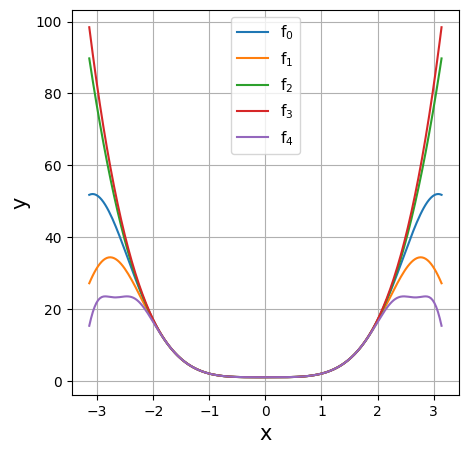

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
#ax.plot(Data_train[0],Data_train[1], 'ko', markersize=2, label='Test Data')
l = []
subopt_func = []
n = 0
t=np.linspace(-2*lim,2*lim,200)
for i in range(len(subopt)):
    l_i = Loss(Results[subopt[i]][1],Data_train[0],Data_train[1],Results[subopt[i]][2])
    siguiente = False
    for j in range(len(l)):
        if abs(l_i-l[j])<10**-8:
            siguiente = True
    if siguiente:
        continue
    subopt_func.append(Results[subopt[i]][3])
    function_aux = Results[subopt[i]][0]
    for j in range(len(Results[subopt[i]][2])):
        function_aux = function_aux.subs(f'par{j}',float(f'{Results[subopt[i]][2][j]:.1e}'))
    print(i,f'f$_{n}$={function_aux}, Loss={l_i}, Error={abs(Loss(Results[subopt[i]][1],Data_train[0],Data_train[1],Results[subopt[i]][2])-Best_Opt[4])/Best_Opt[4]*100}')
    l.append(l_i)
    f_pred = Results[subopt[i]][1](t,*Results[subopt[i]][2])
    ax.plot(t, f_pred, '-', linewidth=1.5,label=f'f$_{n}$')
    n+=1
plt.legend(fontsize=11)
plt.ylabel('y',fontsize=15)
plt.xlabel('x',fontsize=15)
plt.grid()
plt.savefig(f"{images_dir}/FinalTest_lims2.png")
plt.show()

## Noise analysis

The generated dataset contains a gaussian statistic noise. The standard deviation used until here is $\sigma=0.01$. This value is too small to interfere with the code analysis. In this section, a small analysis is made executing the code with the next three values of the standard deviation for the statistic noise.

+ $\sigma=0.01$
+ $\sigma=0.5$
+ $\sigma=5$

### Generation of test dataset with different $\sigma$

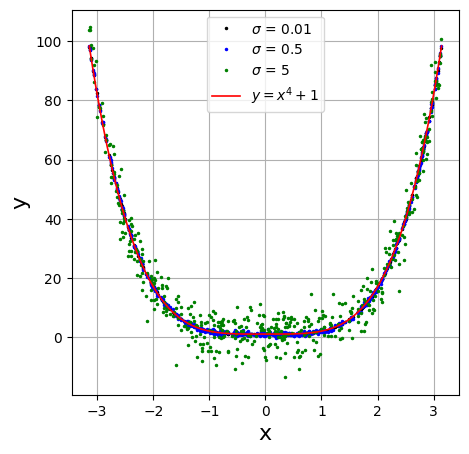

In [8]:
N_data=500
mu_err=0
sigma_err=[.01,.5,5]
coef = [1, 0, 0, 0, 1]

lim = np.pi
x=lim*(2*np.random.rand(N_data)-1)

Data_train = []

for i in range(len(sigma_err)):
    err=sigma_err[i]*np.random.randn(N_data)+mu_err
    y=func_pol(coef,x)+err
    Data_train.append([x,y])
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(Data_train[0][0], Data_train[0][1], 'ko', markersize=1.5, label=f'$\sigma$ = {sigma_err[0]}')
ax.plot(Data_train[1][0], Data_train[1][1], 'bo', markersize=1.5, label=f'$\sigma$ = {sigma_err[1]}')
ax.plot(Data_train[2][0], Data_train[2][1], 'go', markersize=1.5, label=f'$\sigma$ = {sigma_err[2]}')
t=np.linspace(-lim,lim,300)
f=func_pol(coef,t)

ax.plot(t, f, '-', c='r', linewidth=1.2, label='$y=x^4+1$')
plt.legend()
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)

plt.grid()
#plt.savefig(f"{images_dir}/DataGen_sig.png")
plt.show()

### Optimal function search for each $\sigma$

In [9]:
'''
depend(list): Lista con las dependencias a comparar en notación polaca inversa.
func_test(list): Lista similar a depend pero con las posiciones "señuelo" para los parámetros.
var:Lista con el nombre de las variables como carácteres en las funciones.
var_sym(list): Lista con el nombre de las variables en Sympy en las funciones.
'''
import scipy as sci
from scipy.optimize import curve_fit

from sympy.utilities.lambdify import lambdify

var = ['x']
var_sym = [sym.symbols(variable) for variable in var]

depend = Gen_string_1ton(8,var)
Total = 0
for d in depend:
    Total += len(depend[d])
print('Cantidad de dependencias test: ',Total)

func_test = {s:[Intr_param(expression) for expression in depend[s]] for s in depend}

n = {sig:0 for sig in sigma_err}
Results = {sig:[] for sig in sigma_err}
for i in range(len(sigma_err)):
    for s in func_test:
        print(s)
        for j in range(len(func_test[s])):
            try:
                func_sym,params_sym = LeerOp(func_test[s][j],var_sym)
            except:
                print('Error al leer',func_test[s][j],var_sym)
            ind_term = sym.symbols("par"+str(len(params_sym)))
            func_sym = func_sym + ind_term
            params_sym.append(ind_term)
            func_lambda = lambdify(var_sym + params_sym,func_sym, 'numpy')
            try:
                optimal = curve_fit(func_lambda,Data_train[i][0],Data_train[i][1])
                params_num = optimal[0]
                Results[sigma_err[i]].append([depend[s][j],func_sym,func_lambda,params_num])
            except:
                n[sigma_err[i]] += 1

print(n)
#print(Results)

Cantidad de dependencias test:  6596
1
2
3
4
5
6


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
{0.01: 484, 0.5: 441, 5: 454}


In [25]:
Best_Opt = {}
subopt = {}

for i in range(len(sigma_err)):
    print('sigma=',sigma_err[i])
    n = 0
    subopt[sigma_err[i]] = []
    del l_opt
    for j in range(len(Results[sigma_err[i]])):
        l = Loss(Results[sigma_err[i]][j][2],Data_train[i][0],Data_train[i][1],Results[sigma_err[i]][j][3])
        if Results[sigma_err[i]][j][0] == 'xxxx***':
            print('Error de x$^4$: ',l)
        try:
            #print(option[0],l,l_opt)
            if l<l_opt:
                print(l,Results[sigma_err[i]][j][0])
                l_opt = l
                Best_Opt[sigma_err[i]] = Results[sigma_err[i]][j] + [l_opt]
        except:
            l_opt = l
            Best_Opt[sigma_err[i]] = Results[sigma_err[i]][j] + [l_opt]
    for j in range(len(Results[sigma_err[i]])):
        l = Loss(Results[sigma_err[i]][j][2],Data_train[i][0],Data_train[i][1],Results[sigma_err[i]][j][3])
        if l<2*l_opt:
            n  +=1
            subopt[sigma_err[i]].append(j)
print(Best_Opt)

sigma= 0.01
27845.23624653839 xx*
27559.78745138756 xxx*+
22503.899671805968 xcxx*+
5985.6339113807435 xxxc**
4409.233966874846 xcxx**
Error de x$^4$:  0.04938123902840663
0.04938123902840663 xxxx***
sigma= 0.5
28001.87266446436 xx*
27736.15074299187 xxx*+
22723.16461494573 xcxx*+
6090.37848704054 xxxc**
4507.886334272584 xcxx**
Error de x$^4$:  125.70953059154446
125.70953059154446 xxxx***
sigma= 5
42315.13998020868 xx*
41986.604877268 xxx*+
39648.83707396113 xcxx*+
19611.046548683356 xxxc**
17457.45094652153 xcxx**
Error de x$^4$:  12515.539640865316
12515.539640865316 xxxx***
{0.01: ['xxxx***', par0*x**4 + par1, <function _lambdifygenerated at 0x7da7f0b49bd0>, array([1.00000339, 0.99995133]), 0.04938123902840663], 0.5: ['xxxx***', par0*x**4 + par1, <function _lambdifygenerated at 0x7da7efeea3b0>, array([0.99967354, 0.99915092]), 125.70953059154446], 5: ['xxxx***', par0*x**4 + par1, <function _lambdifygenerated at 0x7da7ef2eab90>, array([1.00029166, 1.07534871]), 12515.539640865316]}

In [13]:
for i in range(len(sigma_err)):
    print(len(subopt[sigma_err[i]]))

2
2
45


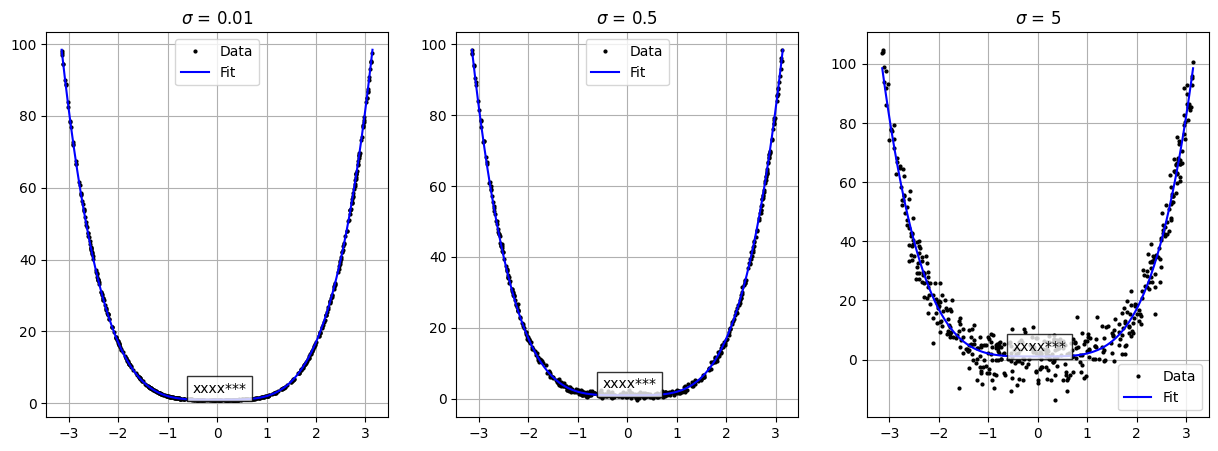

In [27]:
#Optimal function plots

props = dict(facecolor='white',alpha=0.8)
fig,ax = plt.subplots(1,len(sigma_err),figsize=(5*len(sigma_err),5))
t = np.linspace(-lim,lim,200)

for i in range(len(sigma_err)):
    ax[i].plot(Data_train[i][0], Data_train[i][1], 'ko', markersize=2, label='Data')
    f_pred = Best_Opt[sigma_err[i]][2](t,*Best_Opt[sigma_err[i]][3])
    ax[i].plot(t, f_pred, '-', c='blue', linewidth=1.5, label='Fit')#+names[i])

    #ax[i].text(-0.5,3,f'Error={Results[sigma_err[i]][1][3]:.2e}',bbox=props)
    ax[i].text(-0.5,3,Best_Opt[sigma_err[i]][0],bbox=props)
    ax[i].legend()
    ax[i].grid()
    ax[i].set_title(f'$\sigma$ = {sigma_err[i]}')

#plt.savefig(f"{images_dir}/noise1.png")
plt.show()


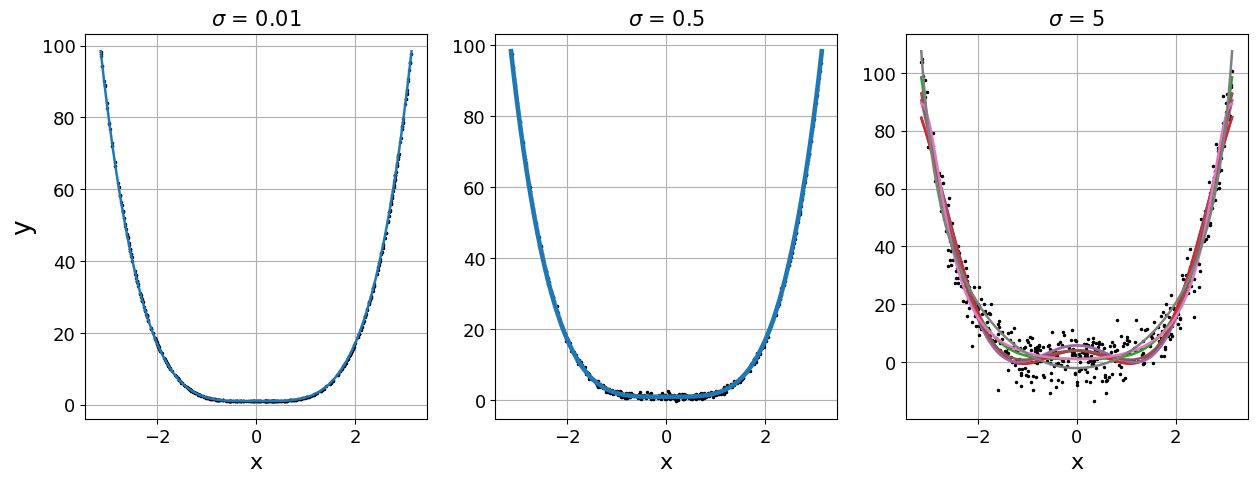

In [14]:

#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
props = dict(facecolor='white',alpha=0.8)

fig,ax = plt.subplots(1,len(Results),figsize=(5*len(Results),5))
#ax.plot(Data_train[0],Data_train[1], 'ko', markersize=2, label='Data')
l = []
t=np.linspace(-lim,lim,200)
for i in range(len(sigma_err)):
    #print('sigma=',sigma_err[i])
    l = []
    n = 0
    ax[i].plot(Data_train[i][0], Data_train[i][1], 'ko', markersize=1.5, label='Train Data')
    for k in range(len(subopt[sigma_err[i]])):
        l_i = Loss(Results[sigma_err[i]][subopt[sigma_err[i]][k]][2],Data_train[i][0],Data_train[i][1],Results[sigma_err[i]][subopt[sigma_err[i]][k]][3])
        siguiente = False
        for j in range(len(l)):
            if abs(l_i-l[j])<10**-8:
                siguiente = True
        if siguiente:
            continue
        l.append(l_i)
        function_aux = Results[sigma_err[i]][subopt[sigma_err[i]][k]][1]
        for j in range(len(Results[sigma_err[i]][subopt[sigma_err[i]][k]][3])):
            function_aux = function_aux.subs(f'par{j}',Results[sigma_err[i]][subopt[sigma_err[i]][k]][3][j])
        f_pred = Results[sigma_err[i]][subopt[sigma_err[i]][k]][2](t,*Results[sigma_err[i]][subopt[sigma_err[i]][k]][3])
        if i==1 and n==0:
            #print(i,n)
            ax[i].plot(t, f_pred, '-', linewidth=3.3, label='Ajuste')
        else:
            ax[i].plot(t, f_pred, '-', linewidth=1.8, label='Ajuste')
        n+=1
        #print(Results[sigma_err[i]][subopt[sigma_err[i]][k]][1],function_aux,Results[sigma_err[i]][subopt[sigma_err[i]][k]][0],Loss(Results[sigma_err[i]][subopt[sigma_err[i]][k]][2],Data_train[i][0],Data_train[i][1],Results[sigma_err[i]][subopt[sigma_err[i]][k]][3]),abs(Loss(Results[sigma_err[i]][subopt[sigma_err[i]][k]][2],Data_train[i][0],Data_train[i][1],Results[sigma_err[i]][subopt[sigma_err[i]][k]][3])-Best_Opt[sigma_err[i]][4])/Best_Opt[sigma_err[i]][4]*100)
    ax[i].grid()
    ax[i].set_xlabel('x',fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=13)
    ax[i].set_title(f'$\sigma$ = {sigma_err[i]}',size=15)
ax[0].set_ylabel('y',fontsize=19)
#plt.savefig(f"{images_dir}/noise2.png",dpi=640)
plt.show()
